## 7 畳み込みネットワーク

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

## 7.4 Convolution / Poolingレイヤの実装

### 7.4.1 4次元配列

In [3]:
import numpy as np
x = np.random.rand(10, 1, 28, 28) # ランダムにデータを生成
x.shape

(10, 1, 28, 28)

In [4]:
x[0].shape # 1つ目のデータにアクセス. (1, 28, 28)

(1, 28, 28)

In [5]:
x[1].shape # 2つ目のデータにアクセス. (1, 28, 28)

(1, 28, 28)

In [6]:
x[0, 0] # 1チャンネル目の空間データにアクセス, もしくはx[0][0]

array([[9.09533270e-01, 8.09421798e-01, 3.67715211e-01, 8.43121053e-01,
        1.65410966e-01, 1.98924997e-01, 6.69771689e-02, 9.80503040e-01,
        8.39359767e-01, 2.90888511e-01, 6.90995193e-01, 9.00180955e-01,
        4.42173913e-01, 9.89440957e-01, 5.33291895e-01, 1.11394262e-01,
        5.02437656e-01, 6.58743070e-01, 5.95350528e-01, 1.18760188e-01,
        4.80033409e-01, 9.47073188e-01, 5.24927120e-01, 7.45977328e-01,
        7.96999603e-01, 8.13555410e-01, 5.29074731e-01, 9.27013751e-01],
       [5.96400844e-01, 5.09407595e-01, 7.86139941e-01, 2.66238013e-01,
        5.84571995e-01, 9.33653911e-01, 4.64017680e-01, 6.20670629e-01,
        3.11434258e-01, 6.34439835e-01, 1.56386857e-01, 3.48615106e-01,
        2.18069723e-01, 1.90251637e-01, 6.95315993e-01, 1.15854373e-01,
        5.94298426e-01, 5.46264508e-01, 4.65233517e-01, 7.78536091e-01,
        7.11713022e-02, 7.23768902e-01, 6.15601161e-01, 3.52527359e-02,
        6.93806944e-01, 9.62420876e-01, 7.59628067e-01, 9.80796

### 7.4.3 Convolutionレイヤの実装

In [7]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [8]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
coll = im2col(x1, 5, 5, stride = 1, pad = 0)
print(coll.shape) # (9, 75)

x2 = np.random.rand(10, 3, 7, 7) # 10個のデータ
col2 = im2col(x2, 5, 5, stride = 1, pad = 0)
print(col2.shape) #(90, 75)

(9, 75)
(90, 75)


In [9]:
class Convolution: 
    def __init__(self, W, b, stride = 1, pad = 0): 
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self, x): 
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(o, 3, 1, 2)
        
        return out

In [10]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [11]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

### 7.4.4 Poolingレイヤの実装

In [12]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
#        self.x = None
#        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

#        arg_max = np.argmax(col, axis=1)
        # 最大値(2)
        out = np.max(col, axis=1)
        # 最大値(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

#        self.x = x
#        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## 7.5 CNNの実装

In [13]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.300005312929278
=== epoch:1, train acc:0.257, test acc:0.285 ===
train loss:2.296678731892683
train loss:2.29290595798487
train loss:2.290394054500223
train loss:2.2842584927819782
train loss:2.269266615764272
train loss:2.247128573200765
train loss:2.247672921910246
train loss:2.2075937303316184
train loss:2.187165566014709
train loss:2.1699177307928896
train loss:2.1607234528215153
train loss:2.1091515055504524
train loss:2.02225017724931
train loss:2.0252288248824812
train loss:1.9102570556228426
train loss:1.872834731891836
train loss:1.8055677775924752
train loss:1.7790325897736563
train loss:1.6710509981184318
train loss:1.6262022319927265
train loss:1.6100279723377953
train loss:1.4289200815925227
train loss:1.3807725442873846
train loss:1.34477786691045
train loss:1.2168328086965619
train loss:1.1098422660769012
train loss:1.0109694572017134
train loss:1.0770415565190692
train loss:0.8848260828948145
train loss:0.8855315825343717
train loss:0.98165109015833
train l

train loss:0.29978911770812483
train loss:0.22373372982301729
train loss:0.14968593320419757
train loss:0.2500912550211662
train loss:0.2133191896131088
train loss:0.18340317349686586
train loss:0.3583172858491196
train loss:0.11526926744133348
train loss:0.17599750128099648
train loss:0.17170815457673652
train loss:0.08965712552511249
train loss:0.2428448808523237
train loss:0.2579318051152876
train loss:0.24815440217418822
train loss:0.21666868036016473
train loss:0.08207033277251106
train loss:0.1134731225133214
train loss:0.17521225956858785
train loss:0.22247408576372532
train loss:0.3340966075799312
train loss:0.17970134006884927
train loss:0.19762711147268186
train loss:0.18869859898544025
train loss:0.22745630771777922
train loss:0.18958532232283715
train loss:0.15389169579546372
train loss:0.16194560643932512
train loss:0.17953256406630433
train loss:0.09338224717873642
train loss:0.09482710480726858
train loss:0.34926265616459157
train loss:0.2616861180996197
train loss:0.162

train loss:0.04311841583398583
train loss:0.08887208071861742
train loss:0.0652833601311166
train loss:0.1031747772023815
train loss:0.11439054723386613
train loss:0.20678034083133312
train loss:0.15402057219595505
train loss:0.10978328679655748
train loss:0.13137664692172968
train loss:0.06619800032501741
train loss:0.12142320832407957
train loss:0.13087170221941474
train loss:0.0979480513651402
train loss:0.1403736924427386
train loss:0.08106345412061153
train loss:0.09048486520935191
train loss:0.09851056806667179
train loss:0.04975651857608062
train loss:0.15294040874315867
train loss:0.0661590908902223
train loss:0.06461742694178786
train loss:0.09199320277004176
train loss:0.05666362333177379
train loss:0.08035178100840458
train loss:0.0810392562648621
train loss:0.11379554373090132
train loss:0.2630595482164033
train loss:0.09981094452886725
train loss:0.22241517514907913
train loss:0.11500299568537066
train loss:0.08422591843088006
train loss:0.12745703873455078
train loss:0.14

train loss:0.10616213697558177
train loss:0.14422622335161464
train loss:0.043921909537028354
train loss:0.011174947294442412
train loss:0.07920548914475152
train loss:0.05822687475285646
train loss:0.09105947470183744
train loss:0.10372828944742027
train loss:0.14734902816666046
train loss:0.10364914487718019
train loss:0.14685864271605453
train loss:0.16052048997873164
train loss:0.12369756282245908
train loss:0.10361609783874329
train loss:0.09962433924374377
train loss:0.04560022044231138
train loss:0.051007471135592085
train loss:0.03279982741515665
train loss:0.1623630524945129
train loss:0.09459625797806458
train loss:0.08224368539758775
train loss:0.06052825377041608
train loss:0.15333639469130433
train loss:0.03307275936141146
train loss:0.057711195585005336
train loss:0.15765636821088105
train loss:0.13366454977834544
train loss:0.019017895640027614
train loss:0.13489169193726375
train loss:0.053250288269895224
train loss:0.07623711790581407
train loss:0.03956000461371614
tra

train loss:0.0918434150850777
train loss:0.07165894322152376
train loss:0.041411542281776244
train loss:0.04498302003553178
train loss:0.038857593629854276
train loss:0.07509559653819511
train loss:0.08417193488389177
train loss:0.063749411646883
train loss:0.08356217581217808
train loss:0.15528109685396763
train loss:0.1412860784969866
train loss:0.041937518707993726
train loss:0.033903670262770504
train loss:0.10841787583671599
train loss:0.04871626156850738
train loss:0.04195078884684821
train loss:0.029451763380779775
train loss:0.13391988428154952
train loss:0.09650525076587463
train loss:0.1039424026597629
train loss:0.08779580492608949
train loss:0.05467887558466646
train loss:0.026202715078874506
train loss:0.07614291593760654
train loss:0.055208627059525284
train loss:0.031535725215592274
train loss:0.04637125608336937
train loss:0.047836971978230336
train loss:0.039683111391314196
train loss:0.09860485009707841
train loss:0.038632003159354694
train loss:0.0284996792678577
tra

train loss:0.06508639219517603
train loss:0.07919403587386323
train loss:0.02588616569025678
train loss:0.058778164145370564
train loss:0.060300054511214576
train loss:0.05393048607534534
train loss:0.031386443098867234
train loss:0.0836710510682813
train loss:0.05504555947811615
train loss:0.08278248561653394
train loss:0.05605778806758651
train loss:0.0718767713034025
train loss:0.021632740235454473
train loss:0.06769212581547819
train loss:0.10532271210200445
train loss:0.037933598504775706
train loss:0.05916216036335653
train loss:0.052962650783159884
train loss:0.04352187041151849
train loss:0.028405439925074404
train loss:0.0472568052876661
train loss:0.09079478739274689
train loss:0.04723662250029908
train loss:0.14966202847691978
train loss:0.058961501201722194
train loss:0.0680383589425446
train loss:0.05228139577727484
train loss:0.03222932057237257
train loss:0.03850298542081608
train loss:0.056145043576447826
train loss:0.042628805041943316
train loss:0.041128840904412926
t

train loss:0.026661292072880483
train loss:0.0431230948516732
train loss:0.10146335520719235
train loss:0.01914619593487887
train loss:0.033565448158405016
train loss:0.053791513517485026
train loss:0.02681090986252957
train loss:0.03272722249710243
train loss:0.030256108943965777
train loss:0.017328836768882184
train loss:0.03942405068250347
train loss:0.027913091960102106
train loss:0.08391875357082741
train loss:0.029116420292089114
train loss:0.0377364338181912
train loss:0.09745083701193223
train loss:0.04474539890634639
train loss:0.02017683825441163
train loss:0.019354436474458635
train loss:0.024259419800046585
train loss:0.011788408448999395
train loss:0.09951995106882007
train loss:0.08255131156832082
train loss:0.01844488250522545
train loss:0.01868928764054318
train loss:0.1398080989700384
train loss:0.04666820519894586
train loss:0.12016749175877972
train loss:0.028152622207091676
train loss:0.03889646476890815
train loss:0.07090969482118
train loss:0.029177662301681097
tr

train loss:0.03246090313737072
train loss:0.046256031797942396
train loss:0.05652373586816428
train loss:0.02735497694428842
train loss:0.06712151122914398
train loss:0.08842444514190173
train loss:0.07781941678087095
train loss:0.03384448533604918
train loss:0.012914905040052544
train loss:0.037992022338104746
train loss:0.054690635298618194
train loss:0.054763425844694326
train loss:0.019695083785336208
train loss:0.03504654117006525
train loss:0.032664679924555726
train loss:0.047104025562192724
train loss:0.035693961227573144
train loss:0.03113482591728748
train loss:0.012165443223962014
train loss:0.01966622423303695
train loss:0.04816082412762318
train loss:0.015220993114274646
train loss:0.06295072665058939
train loss:0.019325141459840597
train loss:0.028106190626516963
train loss:0.05817864604504983
train loss:0.02504373798485724
train loss:0.059598091695881636
train loss:0.04335209327122137
train loss:0.05453577466798122
train loss:0.029311308150739693
train loss:0.05100738466

train loss:0.07392158921701082
train loss:0.011657069323917652
train loss:0.012068423174065526
train loss:0.02856551439516808
train loss:0.013017735789467933
train loss:0.04367490706405805
train loss:0.02239797007842921
train loss:0.07824229002958555
train loss:0.025557198310201062
train loss:0.012625639120576565
train loss:0.02927786669411546
train loss:0.06278640606287363
train loss:0.04586645888853914
train loss:0.03884576564588685
train loss:0.01840833451944821
train loss:0.03313732419155529
train loss:0.05118744672783688
train loss:0.0401140864960001
train loss:0.05060700496889864
train loss:0.011665129691948752
train loss:0.010915361094070122
train loss:0.016025992768270013
train loss:0.12705164056439355
train loss:0.00990286896531333
train loss:0.02807918095286333
train loss:0.027542985725320393
train loss:0.06104572588557112
train loss:0.05796045871755856
train loss:0.040341681786966815
train loss:0.005941692657494522
train loss:0.03440873286031674
train loss:0.0312963272897872

train loss:0.04748990910410857
train loss:0.028644819875109494
train loss:0.01806143149275782
train loss:0.0526848468542572
train loss:0.025910221971109912
train loss:0.006451823926344072
train loss:0.09979011834497824
train loss:0.015951706213292925
train loss:0.035187196306807056
train loss:0.008660433542421412
train loss:0.028053529798335846
train loss:0.034074125451066146
train loss:0.04343075692798377
train loss:0.027310523838034884
train loss:0.0065840578542087115
train loss:0.05478415875637881
train loss:0.02958842085959047
train loss:0.02237888862146219
train loss:0.009705507287785332
train loss:0.042831338772194985
train loss:0.005594475348154572
train loss:0.007707791142981928
train loss:0.06394179678525348
train loss:0.02859835674706486
train loss:0.03771530649407745
train loss:0.00824923961998822
train loss:0.008121105563321521
=== epoch:5, train acc:0.987, test acc:0.982 ===
train loss:0.023200364548291996
train loss:0.004473586536256496
train loss:0.03009563960045305
trai

train loss:0.016174273798819458
train loss:0.009514438324370121
train loss:0.020979764971681924
train loss:0.011391283448853727
train loss:0.024256402034589473
train loss:0.05672337119382705
train loss:0.05437554186836961
train loss:0.003347599805140282
train loss:0.016361851619427957
train loss:0.011049054119251405
train loss:0.040297280725103996
train loss:0.005157717773896508
train loss:0.06156816475015435
train loss:0.023896762083573206
train loss:0.021068335408349407
train loss:0.02057878673544494
train loss:0.0267676957029634
train loss:0.031396639999852274
train loss:0.031120933398163412
train loss:0.006066075748997023
train loss:0.05172525076401168
train loss:0.028747007889725715
train loss:0.0830423359106601
train loss:0.05668366950646898
train loss:0.00859665263229515
train loss:0.054800339548942
train loss:0.032568613537979185
train loss:0.012419697164256362
train loss:0.020306367038938723
train loss:0.007375185832096481
train loss:0.01192653024540712
train loss:0.0314888873

train loss:0.007511734370349302
train loss:0.007457454214641652
train loss:0.012708073164112068
train loss:0.04304660930832226
train loss:0.05027564564989588
train loss:0.007012734904000375
train loss:0.008964346839490748
train loss:0.019645159080622806
train loss:0.02269701558904186
train loss:0.03888236428526798
train loss:0.004213890746859436
train loss:0.007004094500269782
train loss:0.010007816771803658
train loss:0.013386486968616228
train loss:0.02724997564420552
train loss:0.017725322553604615
train loss:0.015912957717568205
train loss:0.013364956987170393
train loss:0.04918712152982375
train loss:0.029929004932248048
train loss:0.01420297044355246
train loss:0.006727328414778439
train loss:0.04158230173549579
train loss:0.01939332182194137
train loss:0.06576580777879082
train loss:0.013095546255537587
train loss:0.004937133453937448
train loss:0.02657701157889736
train loss:0.08163075547365127
train loss:0.02129952020741221
train loss:0.004727185789855146
train loss:0.00567003

train loss:0.1393506867164463
train loss:0.008676262670354689
train loss:0.019020469895165468
train loss:0.01038582603398982
train loss:0.027131787073214567
train loss:0.008172581524401751
train loss:0.022948186841699348
train loss:0.009825592671739542
train loss:0.013958538697002023
train loss:0.006735073164542658
train loss:0.0412964426562673
train loss:0.1242858942058829
train loss:0.01767439544622464
train loss:0.01903120836242888
train loss:0.016245947196082453
train loss:0.015178980934633674
train loss:0.006515068024393328
train loss:0.020315747936456886
train loss:0.1243239937200155
train loss:0.05002380113155331
train loss:0.007897477936753996
train loss:0.02531534574801965
train loss:0.07018685221326573
train loss:0.00456778130660477
train loss:0.03613773578051269
train loss:0.013393103367650901
train loss:0.012110605554635761
train loss:0.038725901279014034
train loss:0.006987508462176839
train loss:0.009250356843600573
train loss:0.026404673801749098
train loss:0.08727376749

train loss:0.04981512825199747
train loss:0.02394033525426977
train loss:0.027117999570446708
train loss:0.022192559765658464
train loss:0.03080685302767551
train loss:0.012013646975481802
train loss:0.014294749358264398
train loss:0.011520231278930418
train loss:0.0067430159340091615
train loss:0.0212816188513412
train loss:0.06712646430849406
train loss:0.0021184088366110014
train loss:0.00837259751653893
train loss:0.01687701577601469
train loss:0.040983398315145234
train loss:0.005678325201972102
train loss:0.007950454354993655
train loss:0.027322308656872307
train loss:0.04009671851807072
train loss:0.007081330875276827
train loss:0.013364195687865111
train loss:0.03055202688963116
train loss:0.004300305452997079
train loss:0.007476250077855779
train loss:0.005805161533156523
train loss:0.011860109334524405
train loss:0.006346762098744521
train loss:0.0019301016435930235
train loss:0.011133150044442852
train loss:0.01923382334398549
train loss:0.02555182391216226
train loss:0.0105

train loss:0.045073845924489576
train loss:0.007797663304940175
train loss:0.006820986817200959
train loss:0.015759856966779996
train loss:0.010826797040163778
train loss:0.014562598230668937
train loss:0.012749502764080671
train loss:0.01059498283271399
train loss:0.007953064302883468
train loss:0.013539490219562132
train loss:0.00721488589984004
train loss:0.024691474209676264
train loss:0.014064427522945145
train loss:0.022902955001900743
train loss:0.006331511250483149
train loss:0.0543687614474825
train loss:0.0028890124775279176
train loss:0.025293463158944894
train loss:0.004149437808246498
train loss:0.005418676555339132
train loss:0.02016670976992693
train loss:0.02565144546174566
train loss:0.06333817544901996
train loss:0.01605086550282772
train loss:0.01120249827215486
train loss:0.012700789882849855
train loss:0.006469897183823975
train loss:0.014107298922683848
train loss:0.02190510207497174
train loss:0.013191734807168192
train loss:0.007553960557148925
train loss:0.0292

train loss:0.0014873405623343791
train loss:0.03731296952464585
train loss:0.007794393759527264
train loss:0.0062078078678515745
train loss:0.0050319221026057185
train loss:0.02481979927247909
train loss:0.01636519966500379
train loss:0.001751817936018122
train loss:0.013180288628354093
train loss:0.011924379344657034
train loss:0.01216320574519904
train loss:0.0043358493118618915
train loss:0.009301146947005118
train loss:0.015140646031791476
train loss:0.030397261681158718
train loss:0.010532406938176492
train loss:0.008445766329953629
train loss:0.04617825164657161
train loss:0.01946006192219053
train loss:0.013290305429711956
train loss:0.011017765357366188
train loss:0.028306745671317274
train loss:0.017506031844702487
train loss:0.028995047723771573
train loss:0.014438465567963688
train loss:0.017283141610935873
train loss:0.005581179077002606
train loss:0.002106302543142028
train loss:0.027937324794554703
train loss:0.027807834910247034
train loss:0.01015335914726464
train loss:

train loss:0.10283607908341828
train loss:0.016207751988083344
train loss:0.03458872671431843
train loss:0.015507698905837692
train loss:0.017812336214329278
train loss:0.04869676899963031
train loss:0.006077547808240031
train loss:0.0013094606723363725
train loss:0.009134311070767422
train loss:0.01004181356037674
train loss:0.007793680202661667
train loss:0.013418599982245281
train loss:0.004788871714791579
train loss:0.026154154770075634
train loss:0.012383702214105586
train loss:0.011740211411952582
train loss:0.013985278327705322
=== epoch:8, train acc:0.988, test acc:0.988 ===
train loss:0.024677003756293024
train loss:0.004005074126083817
train loss:0.007114706249595378
train loss:0.017165442316147403
train loss:0.0026540547309904274
train loss:0.003918369185018652
train loss:0.011067601967362641
train loss:0.02136358208950385
train loss:0.04252916824565361
train loss:0.020857723097763823
train loss:0.011954821254131796
train loss:0.015915611617295898
train loss:0.01550615907794

train loss:0.004513957937590281
train loss:0.005317647901602068
train loss:0.019883541103903432
train loss:0.00931587901308949
train loss:0.033403359452682115
train loss:0.0037802373285438107
train loss:0.0062541477940693336
train loss:0.011101616989945752
train loss:0.08106445730211083
train loss:0.010185828216082358
train loss:0.001968335331184553
train loss:0.004563171671321713
train loss:0.0036996635315425363
train loss:0.004894083109822604
train loss:0.009686474750991707
train loss:0.02312932331377943
train loss:0.014042659192771235
train loss:0.00406637364801256
train loss:0.008951469213626719
train loss:0.004427102525940558
train loss:0.010551748511389443
train loss:0.01646838013140465
train loss:0.007850959481444274
train loss:0.03340070961995327
train loss:0.016514032025123877
train loss:0.02289707638564871
train loss:0.008375780079360549
train loss:0.03647197485786594
train loss:0.0033115476050235675
train loss:0.0006787051113000086
train loss:0.005782202587102258
train loss:

train loss:0.0040559199600275625
train loss:0.013162323868761577
train loss:0.05746977241995779
train loss:0.02130296417573325
train loss:0.00359985401109036
train loss:0.010002844809579714
train loss:0.005292317081162313
train loss:0.0030311133456372135
train loss:0.02708337012846853
train loss:0.0014133726518971333
train loss:0.00797753495037195
train loss:0.009142360042219314
train loss:0.001959077814029649
train loss:0.007913863511637302
train loss:0.007900224809699855
train loss:0.08213685609284395
train loss:0.0012820975439406788
train loss:0.002801250555628107
train loss:0.011827309353974637
train loss:0.009182280472896778
train loss:0.004619516398411444
train loss:0.012037891777475518
train loss:0.009479652073042433
train loss:0.03739834436684167
train loss:0.0022297382072010087
train loss:0.0014474525863795518
train loss:0.010193813792649586
train loss:0.0071546430314334795
train loss:0.005980568043055746
train loss:0.0034766900792089135
train loss:0.0009666043146160971
train 

train loss:0.00564026589103292
train loss:0.03857861306804087
train loss:0.027921988074390128
train loss:0.01945489829114765
train loss:0.005994009727041057
train loss:0.0014374467421239894
train loss:0.006378389016072749
train loss:0.028159492804178933
train loss:0.014227848500552556
train loss:0.0006747986722668832
train loss:0.010330260603389024
train loss:0.012652812436157113
train loss:0.0041244559593552966
train loss:0.007592658111579034
train loss:0.0031499144152494045
train loss:0.008176597176229716
train loss:0.00943221952290401
train loss:0.008563670833001713
train loss:0.004293597962016264
train loss:0.0018981985000901126
train loss:0.004429379702811085
train loss:0.005869057381018062
train loss:0.005908803167095475
train loss:0.01252939663230901
train loss:0.0051891159904707594
train loss:0.002122324771094047
train loss:0.0025995169236874543
train loss:0.021212527413757294
train loss:0.010760283228489766
train loss:0.04288589502493543
train loss:0.003718731460463211
train l

train loss:0.00395216414678111
train loss:0.0009345112620015038
train loss:0.019611134347370905
train loss:0.002152880853579625
train loss:0.0034496587680189193
train loss:0.012532467633871471
train loss:0.0033662884596814763
train loss:0.013817061696135035
train loss:0.019398721934473416
train loss:0.004431960388102149
train loss:0.003157511316329619
train loss:0.017932268546208205
train loss:0.021524581348363325
train loss:0.01835011691364162
train loss:0.01414227139927059
train loss:0.006591064929229769
train loss:0.0018355335971195583
train loss:0.011578639971878038
train loss:0.025089164161547085
train loss:0.004577600512066397
train loss:0.004667494049190107
train loss:0.004195164471283861
train loss:0.018754838254408074
train loss:0.024085486861994458
train loss:0.008254173162886529
train loss:0.0158602398511602
train loss:0.03845473614029811
train loss:0.0033211622292289894
train loss:0.006691371917701156
train loss:0.0013629635766045861
train loss:0.003148297047024839
train lo

train loss:0.0042938029141479485
train loss:0.0053091131608821954
train loss:0.006164335416445415
train loss:0.056337917872873525
train loss:0.014776872082491167
train loss:0.0382275404191471
train loss:0.00240226336148207
train loss:0.00396470169469997
train loss:0.006255203548311198
train loss:0.010103596377000505
train loss:0.004916747067996476
train loss:0.004563613518605419
train loss:0.005242784968173063
train loss:0.0012075222918698884
train loss:0.004189761896686422
train loss:0.0037915581400296983
train loss:0.001654026716439839
train loss:0.04119556300262401
train loss:0.0005182012858256086
train loss:0.0014015936669516025
train loss:0.04628091216402206
train loss:0.015027632065841427
train loss:0.005767772685834811
train loss:0.0017574606108961839
train loss:0.00199577076780107
train loss:0.011664334029927273
train loss:0.012530917040825637
train loss:0.004637550953840789
train loss:0.003280715774149964
train loss:0.005962004532009238
train loss:0.01118589177467471
train los

train loss:0.014864499680043698
train loss:0.02654667497507194
train loss:0.007873978323992609
train loss:0.01846121185258312
train loss:0.004715301472415676
train loss:0.00045318857398955444
train loss:0.0057550925518750325
train loss:0.007997801573549
train loss:0.0042995457127400485
train loss:0.014088733377895174
train loss:0.003892414106376087
train loss:0.002321698313663025
train loss:0.0041347193627482935
train loss:0.0132821002935439
train loss:0.008170500649591586
train loss:0.012095699256835714
train loss:0.008981455903389859
train loss:0.009027603796761378
train loss:0.0003550485198086883
train loss:0.025153306269984452
train loss:0.0029400107747391707
train loss:0.008554934992746214
train loss:0.013442116776375681
train loss:0.04913077887767808
train loss:0.011523055730128098
train loss:0.032439263393661606
train loss:0.009145275537755416
train loss:0.0017391604681912746
train loss:0.0036645853697485882
train loss:0.02418519821833666
train loss:0.003368550963388615
train lo

train loss:0.0012707031129200641
train loss:0.009591011981416061
train loss:0.006394293373766423
train loss:0.012403446924291154
train loss:0.007089493851765561
train loss:0.00810884725834379
train loss:0.010122930778618821
train loss:0.005134401895864701
train loss:0.0021358958414976164
train loss:0.005516227017201522
train loss:0.0056267292194359655
train loss:0.01237338070867852
train loss:0.0036140064286192715
train loss:0.001267568489497712
train loss:0.010342843361281398
train loss:0.002101271317877644
train loss:0.006311132689427917
train loss:0.0042950605685500125
train loss:0.0013686414990258771
train loss:0.003272928522769331
train loss:0.0026626027415231008
train loss:0.0008949255920358392
train loss:0.02013460805065993
train loss:0.0046994960941759804
train loss:0.0024823138370941166
train loss:0.00507136077732661
train loss:0.0018613099287621423
=== epoch:11, train acc:0.998, test acc:0.983 ===
train loss:0.006048015934865551
train loss:0.006369956899842216
train loss:0.01

train loss:0.018680665010444287
train loss:0.00420273569326635
train loss:0.004013868510990386
train loss:0.052673857937884414
train loss:0.04180497840745783
train loss:0.0010759137863296509
train loss:0.013686421425602257
train loss:0.0023430459944029053
train loss:0.003973290204671545
train loss:0.02815896016230555
train loss:0.006762701672937768
train loss:0.00288192262982568
train loss:0.004276510460592234
train loss:0.002068598901553843
train loss:0.006119925776431643
train loss:0.013721063427205154
train loss:0.006121794948181364
train loss:0.002230604461851097
train loss:0.0011986282909392338
train loss:0.0034011986492181166
train loss:0.002745891135667517
train loss:0.019873235254545412
train loss:0.0021855416759988837
train loss:0.005414176261738354
train loss:0.009948065150057092
train loss:0.009799295371578549
train loss:0.0036056220013766615
train loss:0.02745365616199609
train loss:0.0022713843923360525
train loss:0.004406407969006058
train loss:0.006858609899465859
train 

train loss:0.00782946468290857
train loss:0.00863858728813826
train loss:0.0004891530410694254
train loss:0.004633994092037581
train loss:0.0067379482024920116
train loss:0.17131225487248475
train loss:0.0005260221970332592
train loss:0.006013560010130758
train loss:0.02675890318991568
train loss:0.005565206938775385
train loss:0.008706339850146218
train loss:0.0028028047940210766
train loss:0.006880954641192382
train loss:0.0038311763347334254
train loss:0.0012339801862205884
train loss:0.005109778877450335
train loss:0.01101886934255938
train loss:0.014331996186751288
train loss:0.0057189290995302185
train loss:0.006435811575244274
train loss:0.004244058078051242
train loss:0.0026243395072302962
train loss:0.006120936061547722
train loss:0.009112759890612042
train loss:0.0013644658049678429
train loss:0.026366235284733162
train loss:0.0024713700930455054
train loss:0.0012145096649925676
train loss:0.003484580753229444
train loss:0.0016420367512761421
train loss:0.010007712287288391
t

train loss:0.0021418731745294663
train loss:0.009179523309543202
train loss:0.0018515835307789364
train loss:0.002117476974100021
train loss:0.002539003248133079
train loss:0.0016898876410534934
train loss:0.0007933859539969487
train loss:0.0041276120386666984
train loss:0.002472831636462383
train loss:0.002102501461679175
train loss:0.0038847099230598374
train loss:0.001153933602367557
train loss:0.00136691056013601
train loss:0.0016362645639764598
train loss:0.0034364699901622735
train loss:0.007589914652633929
train loss:0.0009828166476033163
train loss:0.018045329306590835
train loss:0.002911526370342376
train loss:0.001025189022503387
train loss:0.0032808613053074798
train loss:0.003404994257943593
train loss:0.0013079089366890356
train loss:0.03580386893493705
train loss:0.001605993328861076
train loss:0.0009185789121704692
train loss:0.0017681146869703952
train loss:0.0006943280803090619
train loss:0.007588074145337089
train loss:0.024618798669332885
train loss:0.018637866456892

train loss:0.016197154319358618
train loss:0.006298148811446103
train loss:0.005987299684295092
train loss:0.017972375050954083
train loss:0.00069456452503249
train loss:0.0014422127931206653
train loss:0.0009977987980201246
train loss:0.00987208927044574
train loss:0.0022717328415717323
train loss:0.0020848239279171333
train loss:0.0035570597746995207
train loss:0.003429182660178276
train loss:0.0006112244591644675
train loss:0.002081898364961524
train loss:0.004832422658672732
train loss:0.006121756108657879
train loss:0.007259596420474056
train loss:0.0031343022259770568
train loss:0.0020234921727760955
train loss:0.002215977873878272
train loss:0.002387538243100615
train loss:0.00379250274962866
train loss:0.016800167407151616
train loss:0.013165974742870847
train loss:0.0013622980506214633
train loss:0.001083087042355893
train loss:0.012450544206016927
train loss:0.005537511135554321
train loss:0.0009743358833117458
train loss:0.0014878669726761887
train loss:0.00991700914615246
t

train loss:0.002589554419800599
train loss:0.0014777082498264587
train loss:0.010629384191323511
train loss:0.00025212595180391706
train loss:0.0020580354892723064
train loss:0.0026031651969191994
train loss:0.01880116071675617
train loss:0.002565868222538615
train loss:0.0023562866013538053
train loss:0.002163687851205966
train loss:0.0006739859405282439
train loss:0.017921822571951858
train loss:0.000735267536147477
train loss:0.0013670132640003845
train loss:0.003050080029707638
train loss:0.003903282402843085
train loss:0.0063082740590320475
train loss:0.0005960889654252409
train loss:0.002569557024810091
train loss:0.00022057134273295272
train loss:0.0026944046094958037
train loss:0.0029930016166525397
train loss:0.0003159750722060068
train loss:0.0024307679546360737
train loss:0.004389198253402437
train loss:0.0021493052894881186
train loss:0.06004292975182445
train loss:0.0002391668031983317
train loss:0.0011287332569824941
train loss:0.0004204387147841514
train loss:0.001099923

train loss:0.001164572523852034
train loss:0.01691555188285223
train loss:0.0008318517373020172
train loss:0.018792273401256745
train loss:0.0025070477635411002
train loss:0.0004640891408385674
train loss:0.0014400340428841652
train loss:0.0006274803419664073
train loss:0.0016708973789518646
train loss:0.007757209771381368
train loss:0.0015624521824685116
train loss:0.0003629368191909009
train loss:0.002933843165922281
train loss:0.0005318377882290151
train loss:0.024948348865433765
train loss:0.012874623604488378
train loss:0.0015735818947496393
train loss:0.005432179834623428
train loss:0.007225114130010074
train loss:0.005069296390346581
train loss:0.0012850577479550337
train loss:0.0029277202995584783
train loss:0.00720391899275822
train loss:0.002742716386769048
train loss:0.0027489682347975352
train loss:0.006887125103573077
train loss:0.00010593413890480594
train loss:0.0029735391950956626
train loss:0.0007786079637024804
train loss:0.004093017965710199
train loss:0.003611922827

train loss:0.003352783892310239
train loss:0.0012950541126724247
train loss:0.000830391739957439
train loss:0.0008741861409441493
train loss:0.0015282564911096093
train loss:0.012320160851057731
train loss:0.0028635152011230167
train loss:0.017073672716048708
train loss:0.0027044830096340775
train loss:0.0035485327871834322
train loss:0.0006121276558596733
train loss:0.0005098292964718163
train loss:0.0021456637468083616
train loss:0.002191343171936844
train loss:0.003829408296488921
train loss:0.0003406855786714266
train loss:0.03675464940862931
train loss:0.006193997817314089
train loss:0.002485713247172915
train loss:0.00448004802202913
train loss:0.000707800711147885
train loss:0.001319054969631433
train loss:0.024648103834504904
train loss:0.0015198083942827866
train loss:0.0026795985171804803
train loss:0.011544204351375063
train loss:0.0006228069731931565
train loss:0.0008340242097468292
train loss:0.0011560449951314477
train loss:0.010364689356948292
train loss:0.00155591997875

train loss:0.008757236880791709
train loss:0.001165200186159423
train loss:0.0014505944839308524
train loss:0.00603452598482713
train loss:0.00021989625728490082
train loss:0.0017310940084923222
train loss:0.009365075248001162
train loss:0.02694796477284075
train loss:0.0020822318754102295
train loss:0.005845964453940013
train loss:0.0007769826607015354
train loss:0.0003802211798148233
train loss:0.0053857613672152645
train loss:0.040001806678786916
train loss:0.0008813337182392953
train loss:0.003971465753788361
train loss:0.004855113641603973
train loss:0.009726668481224592
train loss:0.004099023080992896
train loss:0.0017377587046280868
train loss:0.0007300388588821319
train loss:0.003154009590890528
train loss:0.0007889917635862402
train loss:0.0013567414367983762
train loss:0.0071071683810004635
train loss:0.0052578402487514974
train loss:0.0005574631042990434
train loss:0.0032459757916752548
train loss:0.002059961320735323
train loss:0.00025425634955166963
train loss:0.0003980645

train loss:0.008306041728458774
train loss:0.0005888871406064254
train loss:0.002944699675362551
train loss:0.0001362422705117386
train loss:0.0010781586235486704
train loss:0.0017029092411005153
train loss:0.005719433959613905
train loss:0.002200184167120729
train loss:0.00037049422580886436
train loss:0.01876103053487528
train loss:0.0425359390281491
train loss:0.00027148294260930314
train loss:0.0002569213344820126
train loss:0.004042588853683626
train loss:0.0031377691330916886
train loss:0.0005189217819295034
train loss:0.0020161153759793047
train loss:0.0010975620543161933
train loss:0.005163878523311111
train loss:0.0033027446319144164
train loss:0.0002734914202064452
train loss:0.0011876921816007665
train loss:0.0008994497173547051
train loss:0.000802801145057557
train loss:0.003243104834496247
train loss:0.006681431004405072
train loss:0.02795862166081164
train loss:0.00017642630975065187
train loss:0.0011882466312910338
train loss:0.00340125335460402
train loss:0.000600015432

train loss:0.0009760654511223052
train loss:0.006579902992151842
train loss:0.0029119876702798624
train loss:0.004573233847947705
train loss:0.0013248855808204985
train loss:0.0001171128961641809
train loss:0.0006641845237992493
train loss:0.0039056194285131346
train loss:0.0019328343454761774
train loss:0.006303176887492671
train loss:0.0049327985728641124
train loss:0.0011427769877242581
train loss:0.004241790588336732
train loss:0.000719467927294218
train loss:0.0022065404001209024
train loss:0.002001736445612692
train loss:0.0015612295594490241
train loss:0.003388564518492688
train loss:0.0003759801742627949
train loss:0.0006780847517059651
train loss:0.0029054365828984473
train loss:0.0005972428750189701
train loss:0.0015505506120043692
train loss:0.004415387708076535
train loss:0.0013227675136427228
train loss:0.0035797955379348956
train loss:0.001910618125173642
train loss:0.006643294721828424
train loss:0.00026377578954847944
train loss:0.00077317892822126
train loss:0.00034147

train loss:0.008540975300881463
train loss:0.002751066004167714
train loss:0.011411777041529568
train loss:0.0012857055330197464
train loss:0.0012709079698119713
train loss:0.0002592614388709237
train loss:0.0008871456139673475
train loss:0.01453940505074329
train loss:0.01432393008910839
train loss:0.0038350138384367375
train loss:0.00043279212200499566
train loss:0.0001529149392843649
train loss:0.0009086613566050124
train loss:0.0004944076126236587
train loss:0.0008112557400048474
train loss:0.0033742200186471687
train loss:0.003167515406935761
train loss:0.0022026802885497495
train loss:0.0012738404131444373
train loss:0.0012493175419161476
train loss:0.02496089004962605
train loss:0.0019988639787002324
train loss:0.0010444260761435682
train loss:0.005371748121377926
train loss:0.0006358985267511856
train loss:0.004884722997167881
train loss:0.0008810568924565021
train loss:0.03793154260535038
train loss:0.006468613470955964
train loss:0.008085858834630243
train loss:0.001743070882

=== epoch:16, train acc:0.998, test acc:0.987 ===
train loss:0.00021993808061083778
train loss:0.0026040145438072197
train loss:0.0004588038002154221
train loss:0.0002507158916296612
train loss:0.0024834534951051483
train loss:0.001979689649364427
train loss:0.005333937116549368
train loss:0.0016063539822083204
train loss:0.023428197071957205
train loss:0.00026124399985685815
train loss:0.0014030226705324619
train loss:0.010066467105780736
train loss:0.013027343644329482
train loss:0.019604779421165754
train loss:0.005449719112877369
train loss:0.0028663456512019636
train loss:0.003914366507483588
train loss:0.0019982719723071578
train loss:0.0015329619682800922
train loss:0.004289453146980721
train loss:0.0003885563480340664
train loss:0.001504600149519598
train loss:0.012096158567894113
train loss:0.005410677354805053
train loss:0.002093584532863001
train loss:0.002924299993767099
train loss:0.002888329796969945
train loss:0.0014406468571364728
train loss:0.0013967551030979466
train 

train loss:0.00033988344576192577
train loss:0.0006969825617432113
train loss:0.0044130450973617966
train loss:0.005901466075349194
train loss:0.029554770935387248
train loss:0.001315829775462526
train loss:0.0017066900916333633
train loss:0.0009166992830980946
train loss:0.0012515937983303515
train loss:0.003185586008810916
train loss:0.002029785356588937
train loss:0.0008802432055818775
train loss:0.0017192095398360033
train loss:0.00039429548018577766
train loss:0.003682295887988925
train loss:0.0002708487741791454
train loss:0.0008249940102666917
train loss:0.0016343983682078516
train loss:0.00013618739094439618
train loss:0.0013637699959908505
train loss:0.0014611178777614805
train loss:0.00019829174471418885
train loss:0.0009533756855872533
train loss:8.73589709507312e-05
train loss:0.003119708088978643
train loss:0.0013441898861672975
train loss:0.0005040632394434255
train loss:0.0004392091673689006
train loss:0.0002163988414586644
train loss:0.00034884479742289633
train loss:0.

train loss:0.003661861073617033
train loss:0.00275572743720884
train loss:0.0005937825618985687
train loss:0.0015343410456570106
train loss:0.001829398312305061
train loss:0.000888661581418924
train loss:0.0028262469974280175
train loss:0.001121022485375303
train loss:0.0009144686563414685
train loss:0.0006238285851749064
train loss:0.04362299354636257
train loss:0.0030562157158552676
train loss:0.001817771796562657
train loss:0.0013081997554423267
train loss:0.0037101223714441412
train loss:0.00040293343881603604
train loss:0.007949644272790952
train loss:0.0010942527877626914
train loss:0.0012000698469182083
train loss:0.0011538517704118116
train loss:0.00153429628479998
train loss:0.004630220711392281
train loss:0.00448613902866286
train loss:0.010879330829965207
train loss:0.000422296588665453
train loss:0.0016718763012114096
train loss:0.0018033825913486932
train loss:0.004554706765240914
train loss:0.013080191905151773
train loss:0.0005858066249743579
train loss:0.001458695768217

train loss:0.0018491744482354118
train loss:0.00038779606686801567
train loss:0.000619057964092762
train loss:0.00023834219666389475
train loss:0.018790289398294815
train loss:0.0013605747960873092
train loss:0.0007717559325873168
train loss:0.004815855431655567
train loss:0.001762988357786941
train loss:0.0028966865204394674
train loss:0.0009372941425574313
train loss:0.002908102539176023
train loss:0.003428895705179902
train loss:0.000241198373554724
train loss:0.00010675595618629123
train loss:0.0005533247315097347
train loss:0.0001457037726576917
train loss:0.0008868849159142375
train loss:9.40140497602119e-05
train loss:0.0008852353941607514
train loss:0.00846526171245524
train loss:0.0002646332357936166
train loss:0.002762952673103439
train loss:0.0009088354708966482
train loss:0.0006147829053324007
train loss:5.9874158044552695e-05
train loss:0.0004373528103424678
train loss:0.0007036623844090013
train loss:0.0005796968151778327
train loss:0.0001225418764566962
train loss:0.0020

train loss:0.0009728828421290621
train loss:0.003098425607601055
train loss:0.0012652688771812221
train loss:0.0010994542593004857
train loss:0.009418548638566218
train loss:0.005359607685731967
train loss:9.385429778091653e-05
train loss:0.0005532069172034388
train loss:0.00036598315543298426
train loss:0.00018727592602039484
train loss:0.001563079519373119
train loss:0.001286163751282001
train loss:0.002257232070457281
train loss:0.002324418675875779
train loss:0.0020061069415651185
train loss:0.0024338978605037485
train loss:0.0007045405589585285
train loss:0.0010595225493736451
train loss:0.004017247430318133
train loss:0.0013649756436786879
train loss:0.000911565517097344
train loss:0.0007318351010507887
train loss:0.0011898574932206931
train loss:0.0009692597103991878
train loss:0.0006534176139342215
train loss:0.0002846334780981114
train loss:0.00019966520128847484
train loss:0.0019255159704073693
train loss:0.00013280139682447204
train loss:0.0016396245604903715
train loss:0.00

train loss:0.002945391905485702
train loss:0.003292730930137655
train loss:0.0003676474042825991
train loss:0.0005761575311243641
train loss:0.04073421637451464
train loss:0.0004542885632034183
train loss:0.032007191371478616
train loss:0.0006756044570323869
train loss:0.0001439589387935445
train loss:0.003137342178938104
train loss:0.0007631834351999155
train loss:0.005022210422632161
train loss:0.000442931661751187
train loss:0.00047134787085559575
train loss:0.000156266398820365
train loss:0.00012443371477065086
train loss:0.002182198577354447
train loss:0.0009414471382644545
train loss:0.0020119827799599125
train loss:0.003615216807160867
train loss:0.002189802031937962
train loss:0.002456090541503292
train loss:0.0021526162226582083
train loss:0.004629034003255221
train loss:0.00037382590325145274
train loss:0.0003909847018576721
train loss:0.00020999941212862218
train loss:0.0014272872788047399
train loss:0.0005879308254653268
train loss:0.015863848211379584
train loss:0.00178988

train loss:0.0016207343369247802
train loss:0.00019897023662678747
train loss:0.0008310217371673021
train loss:0.0009387034762297942
train loss:0.0024028333530154602
train loss:0.0024593554556380623
train loss:0.00029988043737171635
train loss:0.0006023860869229953
train loss:0.0014024419168664063
train loss:0.003509920547888809
train loss:0.01080466426823837
train loss:0.0005748234912189141
train loss:0.0010222656968429029
train loss:0.0030154810966271247
train loss:0.0014694850666028547
train loss:0.0015211217113805828
train loss:0.01563176576532761
train loss:0.001359531900483974
train loss:0.002778540188618714
train loss:0.0011015703559001861
train loss:0.0006240253167986706
train loss:0.0025597727114301315
train loss:0.0009199923368652681
train loss:0.00010334461733677812
train loss:0.0006266143113230636
train loss:0.0021870069771779237
train loss:0.000673195144944973
train loss:0.01736602978368252
train loss:0.004572160849262716
train loss:0.0043638593611501665
train loss:0.00013

train loss:0.0016119545776289547
train loss:0.0010385863144304413
train loss:0.0036855180380654345
train loss:0.0013107493408039078
train loss:0.0010033206972165124
train loss:0.0014284918720597764
train loss:0.0005123496767798546
train loss:0.003505157579492833
train loss:0.0006941642728087236
train loss:0.00018121111692953048
train loss:0.0016531064068494197
train loss:0.0005359361310807946
train loss:0.0012075235555252363
train loss:0.000621250230900669
train loss:0.002629009794002043
train loss:0.0012166034926011735
train loss:0.002039415623739252
train loss:0.0010195469400003684
train loss:0.008183801543146445
train loss:0.0006268532290145911
train loss:0.0027999451225438022
train loss:0.0006706884446229647
train loss:0.0015233826241476468
train loss:0.00011652027699777228
train loss:0.0031690485112033906
train loss:0.00025449517357814414
train loss:0.0020071977326410325
train loss:0.0009711281113327384
train loss:0.0004251093134181802
train loss:0.00024814112005772175
train loss:

train loss:0.002373582051339011
train loss:0.0012470143643887176
train loss:0.0023516013086946437
train loss:0.0006309867090793764
train loss:0.007225526378527248
train loss:0.001991634732648621
train loss:0.0035213097971991776
train loss:0.00040038500958510523
train loss:0.00041056632225468286
train loss:0.005705065547388367
train loss:0.006189996273413262
train loss:0.0009051955419508789
train loss:0.0035714051735767356
train loss:0.0003231828202360212
train loss:0.0010951347951223065
train loss:0.001270340825088075
train loss:0.0005220496264770225
train loss:0.0012396473510728635
train loss:0.0006872935107103197
train loss:0.0040332736045237015
train loss:0.0017737544848141016
train loss:0.000511068247699913
train loss:8.782203154488822e-05
train loss:6.305923582072308e-05
train loss:0.007758546250543698
train loss:0.0014217657345723875
train loss:0.0024279627927546567
train loss:0.0017243073632267172
train loss:0.000306595306705047
train loss:0.0004655509886172657
train loss:0.0005

train loss:0.0010227784554064495
train loss:0.0007553209390498128
train loss:0.0009732715088626124
train loss:0.0006263904192114944
train loss:0.013323986021637592
train loss:0.0015647900141864692
train loss:6.757631558189202e-05
train loss:0.0167298458988513
train loss:0.001023717299278226
train loss:9.573038848522213e-05
train loss:0.0007292439378923491
train loss:0.00033944533610592956
train loss:0.0021294395515841554
train loss:0.00013394239601013697
train loss:0.004147986332696477
train loss:0.0033731943585480566
train loss:0.0006716580688043269
train loss:0.0013889819527660105
train loss:0.0015163473875323922
train loss:8.928163628110953e-05
train loss:0.0018973821663754282
train loss:0.0009092372417248779
train loss:0.0002373695631452393
train loss:0.0036085187132698015
train loss:0.0014063634550708368
train loss:0.00017044026392579824
train loss:0.0010161616559162538
train loss:4.746107549453568e-05
train loss:0.00022784064345909377
train loss:0.0013299884025028074
train loss:4

train loss:0.0007689902939182483
train loss:0.0011896143160825693
train loss:0.0029791933047353435
train loss:0.0017724451004550801
train loss:0.00356873513266659
train loss:0.0003229157703404244
train loss:2.9563514491728217e-05
train loss:0.0001887003592655566
train loss:0.0016484210891342494
train loss:0.0013333463423972722
train loss:0.0003292622776815149
train loss:0.0008343575364352372
train loss:0.001910898437656437
train loss:0.005668988736628748
train loss:0.008161882239456988
train loss:0.012195001033563422
train loss:0.00020221286550778692
train loss:4.905349590037936e-05
train loss:0.0012947913747808058
train loss:2.91451016784223e-05
train loss:0.001997565079723294
train loss:6.484295181669207e-05
train loss:0.016853197513482004
train loss:0.00026823493997006533
train loss:0.0005207751229360601
train loss:0.0008767025764806816
train loss:0.003668314205757276
train loss:0.0009640671656449403
train loss:0.0014835046419001043
train loss:0.02032422911508534
train loss:0.000647

train loss:0.00028816616738635875
train loss:5.567662689486119e-05
train loss:0.0003481943167634468
train loss:0.0011608223715882957
train loss:0.0006776039196392361
train loss:0.001143523109572073
train loss:0.0026590254082711705
train loss:0.0009671142111676392
train loss:0.003851891257880413
train loss:0.000783858312467735
train loss:0.004029037245215801
train loss:0.0014179745594994138
train loss:0.00031160184809169464
train loss:0.01932738175650587
train loss:0.00806894478182254
train loss:0.0016275106758225342
train loss:0.003057990919555841
train loss:0.0002211330170701203
train loss:0.0017584582827022677
train loss:0.0001820731533045993
train loss:0.00011104429387856354
train loss:0.0012455355343131901
train loss:0.0027052462115503707
train loss:0.0007960327893317497
train loss:0.0006021382440937365
train loss:0.003497681258994211
train loss:0.0009111772319801768
train loss:0.0025084129579018132
train loss:0.0030252802865564942
train loss:0.0014998093346673504
train loss:0.0013

train loss:0.002113696349307682
train loss:0.00013112223291044252
=============== Final Test Accuracy ===============
test acc:0.9891
Saved Network Parameters!


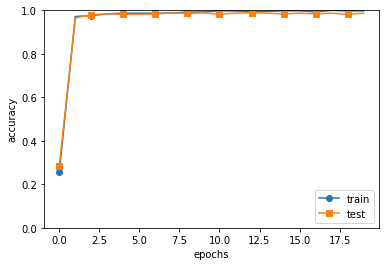

In [14]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

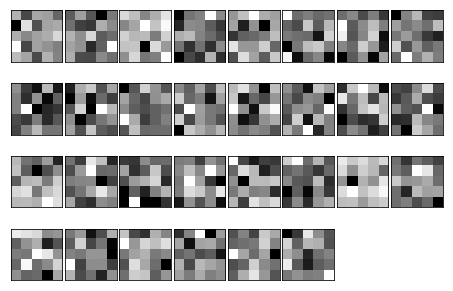

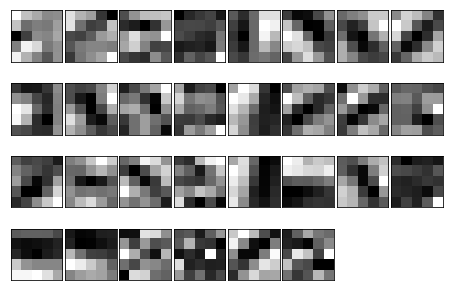

In [15]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])